# Mineração de Dados: Classificação

**Grupo**:

- Gabriel Oliveira Moreira Faria
- Vinícius Oliveira

**Objetivo**:

O objetivo deste trabalho é criar classificadores que buscam prever a aprovação (ou reprovação) de discentes que participaram de um curso online.
Essas bases de dados apresentam características de pessoas que participaram do curso online "Prevenção do uso de drogas".


Os dados estão disponíveis na pasta do drive compartilhada aqui e são formados por 3 arquivos:
"trabalho5_dados_sociais_ID.csv" - dados sócio-econômicos e de perguntas iniciais respondidas pelos participantes,
"trabalho5_dados_modulo1_ID.csv" - dados de acesso ao sistema de ensino durante as atividades referentes ao primeiro módulo do curso, e
"trabalho5_dados_ateh_modulo2_ID.csv" - dados de acesso ao sistema de ensino para as atividades até o segundo módulo do curso.


Nesse trabalho geramos um modelo para cada um das 3 situações a seguir:
1) um modelo que considera apenas as características sócio-econômicos e de perguntas iniciais;
2) um modelo que considera apenas as características sócio-econômicos e de perguntas iniciais, e de acesso considerando o primeiro módulo do curso; e
3) um modelo que considera todos os dados disponíveis.

Para cada uma das 3 situações apresentadas, deve-se gerar ao menos 2 modelos de tipos distintos.

**Com a importância de analisar os parâmetros que fornecemos para os modelos**

In [341]:
# import das bibliotecas

import itertools as it
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# arvore de decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# pygraphviz
import pygraphviz as pgv
from PIL import Image

# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
np.set_printoptions(precision=2)

## Leitura dos dados e Tratamento dos dados
---

Primeiro, carregaremos os dados e analisaremos as características sócio-econômicas, perguntas e dados do sistem de ensino providos a partir da base de dados.


### Conjunto de dados

Primeiramente, vamos carregar as bases de dados


In [342]:
# Características
df_sociais = pd.read_csv("data/trabalho5_dados_sociais_4.csv")
df_modulo1 = pd.read_csv("data/trabalho5_dados_modulo1_4.csv")
df_modulo2 = pd.read_csv("data/trabalho5_dados_ateh_modulo2_4.csv")

#### Utilizaremos os cabeçalhos das perguntas, dos dados do mesmo dataset que usamod no trabalho 2

In [343]:
#Nome das questões vindas do Trabalho 2
pp_questions = pd.read_csv('../p2/data/praticasprofissionais_questions.csv')

# adiciona o indice das questões, que são de pp001 a pp037
pp_questions.index = pd.Series(pp_questions.index).astype('int').add(101).astype('str').str.replace('^1', 'pp0').to_list()

# cria dicionário para renomear colunas
pp_questions_dict = pp_questions.to_dict()['Item']

# cria uma lista das colunas das questoes
pp_questions = list(pp_questions_dict.values())

<ipython-input-343-7e526bcf8546>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  pp_questions.index = pd.Series(pp_questions.index).astype('int').add(101).astype('str').str.replace('^1', 'pp0').to_list()


In [344]:
# Renomeia coluna das perguntas de praticas profissionais

df_sociais = df_sociais.rename(columns=pp_questions_dict)

# Análises exploratórias e entendimento dos dados

- Distribuição das pessoas em  suas características a respeito do curso
- Quantidade de aprovados e não aprovados
- Quantidade de alunos que não iam nas aulas ou não faziam as atividades



Todo essas análise corrobora para a escolha certa de parâmetros e ajuda no entendimento das classficações que serão feitas abaixo

In [345]:
# Distribuição dos rótulos
data = pd.DataFrame(data=y, columns=["aprovado"]).value_counts().to_frame()
data / data.sum()

,0
aprovado,
0,0.566
1,0.434


A distribuição mostra que um classificador "naive" é capaz de uma acurácia de 57%.

### Vemos que a distribuição entres as classes é bem balanceada, apenas os que não passaram tem 56%

<AxesSubplot:xlabel='aprovado'>

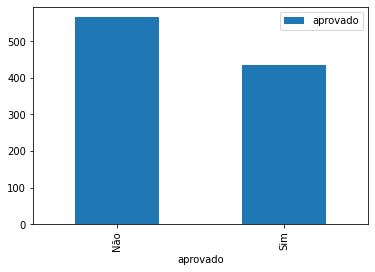

In [346]:
df_sociais.groupby('aprovado').agg({'aprovado': 'count'}).plot.bar()

### Tratamento dos dados
---


#### Separação dos dados

 Agora após as análises iniciais, vamos separar os rótulos que serão preditos.

In [347]:
# Ordenação pelo id, para ter certeza da ordem do dataset
df_sociais = df_sociais.sort_values('id')
df_modulo1 = df_modulo1.sort_values('id')
df_modulo2 = df_modulo2.sort_values('id')


In [348]:
# Rótulos
y = LabelEncoder().fit(["Sim", "Não"]).transform(df_modulo2["aprovado"])
df_sociais = df_sociais.drop(["id", "aprovado"], axis=1)
df_modulo1 = df_modulo1.drop(["id", "aprovado"], axis=1)
df_modulo2 = df_modulo2.drop(["id", "aprovado"], axis=1)

### Pré-processamento

A base de dados sociais é a única que possui variáveis multi-categóricas e ordinais não processadas. Vamos pré-processá-las para que possam ser usadas pelos classificadores.


In [349]:
# Ordens das categorias
sn_cat = ["Sim", "Não"]
sexo_cat = ["Feminino", "Masculino"]
escolaridade_cat = [
    "Ensino Médio Completo",
    "Ensino Superior Incompleto",
    "Ensino Superior Completo",
    "Pós-graduação",
]
materialdidatico_cat = ["Adequado", "Muito adequado"]
prazoatividades_cat = [
    "Pouquíssimo flexível",
    "Pouco flexível",
    "Flexível",
    "Muito flexível",
]
interacaopares_cat = ["Importante", "Muito importante"]
organizacaocurso_cat = ["Organizado", "Muito organizado"]
import_ajud_tutor_cat = ["Às vezes", "Sempre"]
autoavaliacao_cat = [
    "Não, não considero",
    "Sim, considero, porém, poderia estar me esforçando mais",
    "Sim, considero",
]
pp_cat = [
    "Discordo totalmente",
    "Discordo",
    "Nem discordo, nem concordo",
    "Concordo",
    "Concordo totalmente",
]

In [350]:
# Variáveis ordinais
cols_ord = [
    "escolaridade",
    "materialdidatico",
    "prazoatividades",
    "interacaopares",
    "import.ajud.tutor",
    "autoavaliacao.x",
] + pp_questions # [f"pp{n + 1:03}" for n in range(37)]
cats_ord = [
    escolaridade_cat,
    materialdidatico_cat,
    prazoatividades_cat,
    interacaopares_cat,
    import_ajud_tutor_cat,
    autoavaliacao_cat,
] + [pp_cat] * 37

# Variáveis nominais
cols_nom = list(set(df_sociais.select_dtypes(object).columns) - set(cols_ord))

# Variáveis numéricas
cols_num = ["idade", "tempodeservico"]

## Funções desenvolvidas para rodar os modelos e funções utilitárias
---

Função necessária para fazer o GridSearch dos modelos, verificando resultados dos modelos de LogisticRegression, GradientBoostingClassifier e RandomForestClassifier

In [351]:
def search_results(X, y, column_combinations, results_path, cache=True):
    try:
        if cache:
            with open(results_path, "rb") as file:
                search_results = pickle.load(file)
        else:
            raise FileNotFoundError()
    except FileNotFoundError:
        search_results = []
        for cols in column_combinations:
            cols_ord_ = list(set(cols_ord) & set(cols))
            cats_ord_ = [cats_ord[cols_ord.index(x)] for x in cols_ord_]
            cols_nom_ = list(set(cols_nom) & set(cols))
            cols_num_ = list(set(cols_num) & set(cols))

            transformers = []
            if cols_ord_:
                transformers.append((OrdinalEncoder(categories=cats_ord_), cols_ord_))
            if cols_nom_:
                transformers.append((OneHotEncoder(), cols_nom_))
            if cols_num_:
                transformers.append((StandardScaler(), cols_num_))

            steps = []
            if transformers:
                steps.append(("transformer", make_column_transformer(*transformers)))
            steps.append(("estimator", LogisticRegression())),  # dummy
            pipe = Pipeline(steps)

            search = GridSearchCV(
                pipe,
                param_grid=[
                    {
                        "estimator": [LogisticRegression()],
                    },
                    {
                        "estimator": [GradientBoostingClassifier()],
                    },
                    {
                        "estimator": [RandomForestClassifier()],
                    },
                ],
                n_jobs=-1,
            )
            _ = search.fit(X[cols], y)

            result = pd.DataFrame(search.cv_results_)
            result["columns"] = [cols] * len(result)
            search_results.append(result)

        search_results = pd.concat(search_results).sort_values(
            by="mean_test_score", ascending=False
        )
        with open(results_path, "wb") as file:
            pickle.dump(search_results, file)

    return search_results

Função necessária para gerar e imprimir a árvore de decisão dentro do notebook

In [352]:
def decisionTreeToGraph(modelDt, columns, class_names, saveFileName):
    expModelo = tree.export_graphviz(modelDt, out_file=None, feature_names=columns, class_names=class_names, filled=True, rounded=True, special_characters=True)
    grafo = pgv.AGraph(expModelo)



    details = open('details_parameters.txt','a')
    details.write(saveFileName + '\n')
    details.write(str(modelDt.get_params(deep=False)) + '\n\n')
    details.close()

    formatImg = 'png' # eps
    saveFileName += '.' + formatImg
    grafo.draw(saveFileName, formatImg, 'dot')

    display(Image.open(saveFileName))

Função necessária para rodar a árvore de decisão

In [353]:
def decisionTree(X, y, saveFileName='decisionTree', insideDTreeBalancing=False):

    if(insideDTreeBalancing):
        modelo = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 0.01, min_samples_split = 0.1, max_leaf_nodes = 12, min_impurity_decrease=0.01, class_weight='balanced')# min_samples_split = 0.2
    else:
        modelo = DecisionTreeClassifier(criterion='entropy', min_samples_leaf = 0.01, min_samples_split = 0.1, max_leaf_nodes = 12, min_impurity_decrease=0.01)

    # criterion='entropy', min_samples_leaf = 0.01, min_samples_split = 0.1, max_leaf_nodes = 8, min_impurity_decrease=0.01
    # max_leaf_nodes = 10
    # min_samples_leaf = 5
    # min_samples_split
    # max_depth = None
    # min_impurity_decrease=0.005

    modelo.fit(X,y)

    decisionTreeToGraph(modelo, X.columns, ['aprovado', 'não aprovado'], saveFileName)

    return modelo

Função responsável pela plotagem da matriz de confusão

In [354]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ''' -----> Print solution of confusion matrix in letters
    #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    print(cm)
    '''

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




Função necessária para gerar uma matriz de confusão, a partir de um modelo passado por parâmetro e dados para divisão de treino e teste

In [355]:
def make_confusion_matrix(X, y, model, nameOfPlot):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    print('X_treino:', len(X_train), round(len(X_train)/len(X), 2))
    print('X_teste:', len(X_test), round(len(X_test)/len(X),2))
    print('y_treino:', len(y_train), round(len(y_train)/len(y),2))
    print('y_teste:', len(y_test), round(len(y_test)/len(y),2))

    #model = tree.DecisionTreeClassifier()
    model.fit(X_train, y_train)

    y_predict = model.predict(X_test)

    model_acuracy_score = accuracy_score(y_test, y_predict)


    result_confusion_matrix = pd.DataFrame(
        confusion_matrix(y_test, y_predict),
        columns=['Predicted Unconfirmed', 'Predicted Confirmed'],
        index=['True Unconfirmed', 'True Confirmed']
    )


    ########## Impressão do gráfico da Matriz de Confusão 
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    class_names = np.asarray(['aprovado', 'não aprovado'])

    #plot_confusion_matrix(y_test, y_predict, classes=class_names, title=nameOfPlot)

    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_predict, classes=class_names, normalize=True, title= (nameOfPlot)) # + ' Normalized'))

    plt.show()
    ########## FIM Impressão do gráfico da Matriz de Confusão



    print('Acurácia do modelo', model_acuracy_score, '\n')
    #print(result_confusion_matrix)
    return result_confusion_matrix # model_acuracy_score, 

## Estudos das características

- Verificado as importâncias das features usando Floresta Aleatória
- Utilzamos 1000 árvores na floresta aleatória com altura máxima de 2
- A ideia é verificar novas alturas e mudar ainda mais os parâmetros para o próximo trabalho
- Porém para estudar a importância das features achamos que é o suficiente

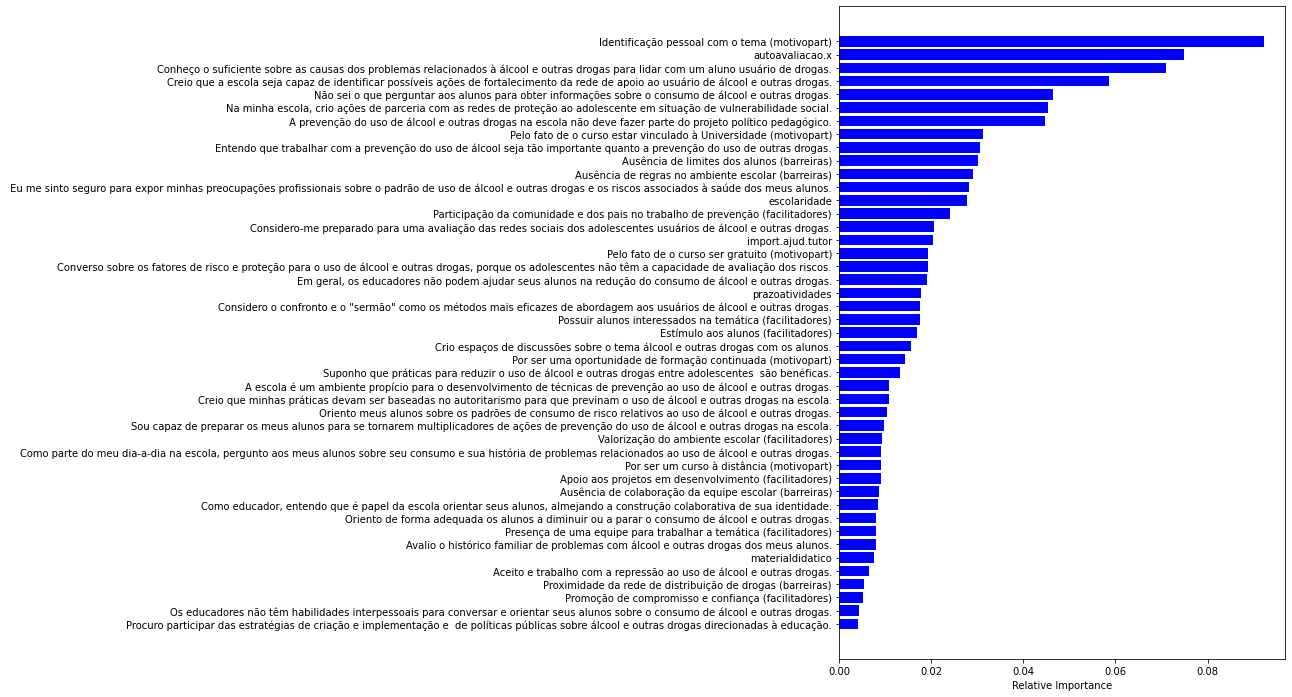

acc = 0.57
f1  = 0.0182648401826484


In [356]:
df_test = pd.concat([df_sociais.drop(cols_nom, axis=1), df_modulo1, df_modulo2], axis=1)
pipe = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    ("ord", OrdinalEncoder(categories=cats_ord), cols_ord),
                    ("num", StandardScaler(), cols_num),
                ]
            ),
        ),
        ("clf", RandomForestClassifier(n_estimators=1000, max_depth=2)),
    ]
)
pipe.fit(X=df_test, y=y)

feature_names = (
    list(set(df_sociais.columns) - set(cols_nom))
    + list(df_modulo1.columns)
    + list(df_modulo2.columns)
)

importances = pipe["clf"].feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 12))
plt.barh(range(len(indices)), importances[indices], color="b", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

y_pred = pipe.predict(X=df_test)
print("acc =", accuracy_score(y, y_pred))
print("f1  =", f1_score(y, y_pred))

- Vimos uma grande força nas variáveis das perguntas de práticas profissionais
- Nos chamou atenção sobre as perguntas de conhecimento sobre as causas do problemas e perguntas mais diretas ao ponto de solução do problema
- Vimos também que as questões de motivação na participação também são importantes, o que é algo que já tínhamos pensado
- Pois quanto maior a motivação, a tendência é que as pessoas estejam mais animadas com o assunto e acham mais importantes que outras pessoas
- A classficicação com floresta aleatória gera melhores métricas para os dados dos 2 módulos juntos, em relação a apenas dados sociais

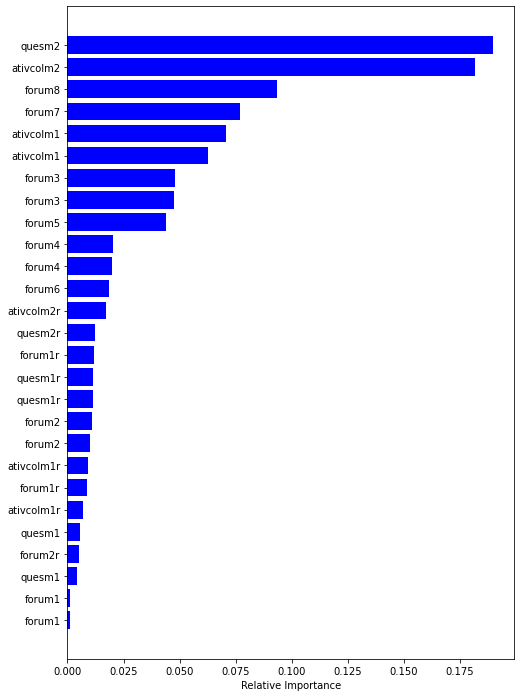

acc = 0.724
f1  = 0.6940133037694013


In [357]:
df_test = pd.concat([df_modulo1, df_modulo2], axis=1)
pipe = Pipeline(
    [
        ("clf", RandomForestClassifier(n_estimators=1000, max_depth=2)),
    ]
)
pipe.fit(X=df_test, y=y)

feature_names = (
    list(df_modulo1.columns)
    + list(df_modulo2.columns)
)

importances = pipe["clf"].feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(8, 12))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

y_pred = pipe.predict(X=df_test)
print("acc =", accuracy_score(y, y_pred))
print("f1  =", f1_score(y, y_pred))

# Situações
- Aqui usamos o que foi construído de funções e gerado os resultados dos classificadores
- No primeiro momento, olhamos mais para os resultados dos classificadores
- Utilizamos uma função que faz a combinação de modelos e gera resultados de vários
- Também fizemos combinações entre as colunas, verificando a possibilidade de alguma combinação de coluna ser melhor para os modelos
- Assim avaliamos quais modelos conseguem gerar o melhor resultado para as situações


# Resultados
- A partir dos resultados podemos perceber que no geral os resultados são melhores quando utilizamos os dados dos módulos do curso
- Ao gerar os modelos apenas com as características sociais, o melhor modelo teve uma acurácia de 0.57 e média 0.53
- E as colunas que nos ajudam a melhor classificar são de dados pessoais, como idade, estado civil, escolaridade e tempo de serviço
- Para os dados apenas dos módulos a acurácia do melhor modelo foi de 0.74 e a média 0.68
- Quando utilizamos os dados em conjunto, tanto de dados sócio-econômicos + módulo 1, quanto todos os dados, o resultado não é melhor que apenas os dados dos módulos
- Porém os resultados, são parecidos com o modelo que só considera características sociais
- Tendo uma pequena, não muito significativa melhora, com melhor resultado entre eles de 0.60 e média de 0.54
- Isso nos traz uma hipótese de na verdade, o que dá mais peso para que alguém seja aprovado, é realmente participar dos encontros, independente de questões sociais e do questionário realizado no início do curso
- Isso pensando que a classe de estudantes são profissionais de educação, e o que mais importa é o engajamento deles no curso, ou seja, a participação

## Situação 1.1 - Características sócio-econômicas e perguntas iniciais

Para primeira situação, dividimos fazendo a análise usando apenas as questões sociais e depois apenas os 2 módulos do curso

In [358]:
column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_sociais.columns) + 1)
    for cols in it.islice(it.combinations(df_sociais.columns, n_cols), 2)
]
results_sociais = search_results(
    X=df_sociais,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_1.pkl",
    cache=False,
)
results_sociais.head()

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
0,0.021344,0.002410,0.005984,6.312035e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.575,0.570,0.57,0.569,0.003742,1,"[idade, sexo, escolaridade, estadocivil, tempo..."
0,0.008977,0.000631,0.002993,4.623108e-07,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,[idade]
0,0.010772,0.000747,0.004189,3.988507e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, escolaridade]"
0,0.023937,0.001261,0.005785,3.989938e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade, ocupacao]"
0,0.020945,0.003512,0.006583,1.196512e-03,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade, estadocivil]"


In [359]:
results_sociais.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,465.000000,465.000000,465.000000,4.650000e+02,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,0.176604,0.007228,0.015200,1.880071e-03,0.536828,0.477656,0.491269,0.506645,0.528978,0.508275,0.031448,1.976344
std,0.097500,0.004588,0.004955,1.384669e-03,0.026423,0.040171,0.035665,0.028864,0.017509,0.017391,0.012119,0.826214
min,0.007980,0.000488,0.001994,4.101908e-07,0.470000,0.405000,0.405000,0.410000,0.470000,0.470000,0.002000,1.000000
25%,0.068702,0.003604,0.011569,7.982136e-04,0.525000,0.450000,0.460000,0.490000,0.520000,0.498000,0.024779,1.000000
50%,0.205051,0.006096,0.015760,1.466576e-03,0.535000,0.465000,0.490000,0.510000,0.525000,0.508000,0.031718,2.000000
75%,0.270082,0.010345,0.018950,2.475569e-03,0.555000,0.495000,0.515000,0.525000,0.535000,0.515000,0.039699,3.000000
max,0.366421,0.024050,0.026130,1.116678e-02,0.615000,0.580000,0.575000,0.570000,0.575000,0.569000,0.061758,3.000000


### Situação 1.2 - Apenas dados dos dois módulos, sem dados sociais

In [360]:
df_modulo = pd.concat([df_modulo1, df_modulo2], axis=1)

column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_modulo.columns) + 1)
    for cols in it.islice(it.combinations(df_modulo.columns, n_cols), 2)
]
results_modulos = search_results(
    X=df_modulo,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_1.pkl",
    cache=False,
)
results_modulos.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
0,0.009974,0.001092,0.001796,3.987559e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.675,0.715,0.740,0.730,0.705,0.713,0.022494,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
0,0.009375,0.000798,0.001994,3.504023e-07,LogisticRegression(),{'estimator': LogisticRegression()},0.675,0.715,0.740,0.720,0.715,0.713,0.021119,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
0,0.008978,0.000631,0.001795,3.986362e-04,LogisticRegression(),{'estimator': LogisticRegression()},0.640,0.735,0.740,0.715,0.720,0.710,0.036194,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
1,0.138233,0.004620,0.002593,4.887530e-04,GradientBoostingClassifier(),{'estimator': GradientBoostingClassifier()},0.675,0.750,0.685,0.745,0.690,0.709,0.031843,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."
1,0.153788,0.002918,0.002394,4.886362e-04,GradientBoostingClassifier(),{'estimator': GradientBoostingClassifier()},0.675,0.750,0.685,0.745,0.690,0.709,0.031843,1,"[quesm1, quesm1r, forum1, forum2, forum3, foru..."


In [361]:
results_modulos.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,159.000000,159.000000,159.000000,1.590000e+02,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,0.094188,0.003107,0.004888,5.774985e-04,0.642453,0.689434,0.675000,0.687044,0.670000,0.672786,0.024237,1.918239
std,0.066375,0.002397,0.003840,5.451655e-04,0.044004,0.054581,0.047524,0.046044,0.042624,0.042934,0.008495,0.834149
min,0.004390,0.000017,0.001595,9.536743e-08,0.520000,0.575000,0.565000,0.585000,0.550000,0.573000,0.003162,1.000000
25%,0.010572,0.001196,0.001995,3.986126e-04,0.632500,0.650000,0.647500,0.657500,0.650000,0.655500,0.017493,1.000000
50%,0.119492,0.002475,0.002591,4.884803e-04,0.655000,0.710000,0.680000,0.700000,0.690000,0.694000,0.026192,2.000000
75%,0.149554,0.004482,0.009474,6.310152e-04,0.675000,0.730000,0.700000,0.722500,0.700000,0.704000,0.031305,3.000000
max,0.189047,0.010797,0.012965,2.497137e-03,0.710000,0.750000,0.765000,0.745000,0.720000,0.713000,0.040125,3.000000


## Situação 2 - Características sócio-econômicas, perguntas iniciais e primeiro módulo do curso

In [367]:
df_all = pd.concat([df_sociais, df_modulo1], axis=1)

column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_all.columns) + 1)
    for cols in it.islice(it.combinations(df_all.columns, n_cols), 2)
]
results_all = search_results(
    X=df_all,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_1.pkl",
    cache=False,
)
results_all.head()

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
0,0.020745,0.001596,0.005586,0.000489,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.575,0.570,0.57,0.569,0.003742,1,"[idade, sexo, escolaridade, estadocivil, tempo..."
0,0.011172,0.000399,0.004587,0.000797,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, escolaridade]"
0,0.023587,0.001323,0.005386,0.000489,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade, ocupacao]"
0,0.020346,0.001954,0.005888,0.000192,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade, estadocivil]"
0,0.015547,0.001353,0.004987,0.000631,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, estadocivil]"


In [368]:
results_all.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,519.000000,519.000000,519.000000,5.190000e+02,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000,519.000000
mean,0.189248,0.008498,0.016270,2.068558e-03,0.537052,0.475983,0.488613,0.507091,0.528102,0.507368,0.031760,1.980732
std,0.106145,0.005729,0.005391,1.721855e-03,0.025154,0.038797,0.036583,0.027858,0.017340,0.017171,0.011649,0.824115
min,0.006183,0.000399,0.001596,2.132481e-07,0.470000,0.405000,0.400000,0.430000,0.470000,0.471000,0.002000,1.000000
25%,0.071206,0.004097,0.012582,7.978321e-04,0.525000,0.450000,0.460000,0.485000,0.515000,0.497000,0.026795,1.000000
50%,0.207844,0.007503,0.017351,1.669979e-03,0.535000,0.465000,0.490000,0.510000,0.525000,0.508000,0.032156,2.000000
75%,0.291442,0.011691,0.019795,2.724143e-03,0.555000,0.495000,0.515000,0.530000,0.535000,0.514000,0.039850,3.000000
max,0.413763,0.039377,0.035196,1.741692e-02,0.605000,0.580000,0.575000,0.570000,0.575000,0.569000,0.064312,3.000000


## Situação 3 - Todos os dados: Características sócio-econômicas, perguntas iniciais, primeiro e segundo módulo do curso (todos os dados)

In [364]:
df_all = pd.concat([df_sociais, df_modulo1, df_modulo2], axis=1)

column_combinations = [
    list(cols)
    for n_cols in range(1, len(df_all.columns) + 1)
    for cols in it.islice(it.combinations(df_all.columns, n_cols), 2)
]
results_all = search_results(
    X=df_all,
    y=y,
    column_combinations=column_combinations,
    results_path="data/search_results_1.pkl",
    cache=False,
)
results_all.head()

C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vinic\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,columns
0,0.020147,0.001596,0.005386,0.000798,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.575,0.570,0.57,0.569,0.003742,1,"[idade, sexo, escolaridade, estadocivil, tempo..."
0,0.007168,0.000759,0.003191,0.000399,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,[idade]
0,0.010573,0.001017,0.004189,0.000399,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo]"
0,0.014163,0.001163,0.004587,0.000489,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, estadocivil]"
0,0.014162,0.000746,0.005386,0.000489,LogisticRegression(),{'estimator': LogisticRegression()},0.565,0.565,0.570,0.565,0.57,0.567,0.002449,1,"[idade, sexo, escolaridade]"


In [365]:
results_all.describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
count,627.000000,627.000000,627.000000,6.270000e+02,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.201602,0.008762,0.017320,2.225765e-03,0.536930,0.474553,0.485742,0.508046,0.527384,0.506531,0.031971,1.974482
std,0.111310,0.005574,0.005411,1.991752e-03,0.023737,0.036609,0.035456,0.028945,0.016070,0.016540,0.010869,0.830327
min,0.006783,0.000743,0.001995,1.784161e-07,0.470000,0.400000,0.410000,0.430000,0.480000,0.466000,0.002000,1.000000
25%,0.075088,0.004318,0.013965,8.922033e-04,0.525000,0.450000,0.460000,0.485000,0.520000,0.495000,0.027495,1.000000
50%,0.241264,0.007652,0.018250,1.844650e-03,0.535000,0.460000,0.485000,0.515000,0.525000,0.508000,0.030822,2.000000
75%,0.306855,0.012106,0.020744,2.966808e-03,0.555000,0.495000,0.510000,0.535000,0.535000,0.514000,0.038781,3.000000
max,0.395203,0.037772,0.036302,2.724413e-02,0.600000,0.580000,0.575000,0.570000,0.575000,0.569000,0.065315,3.000000


## Uso de árvore de decisão para criação dos modelos e análises
---

- Nesta seção faremos a mesma análise feita acima, para as diferentes situações
- Porém, nesse caso iremos utilizar árvore de decisão e plotaremos as mesmas
- Isso é importante, para tentar entender quais regras podemos visualizar diante dos datasets
- Assim poderemos visualizar o que pesa mais para uma classificação com árvore de decisão
- Além disso, nosso intuito é verificar diferentes parâmetros para a árvore de decisão


#### Resultados

- As árvores conseguem classificar melhor a classe de aprovados, tendo uma entropia mais alta no geral
- O balanceamento apesar de ter sido usado, não teve muita interferência no resultado dos modelos
- Isso se deve ao fato dos dados já serem bem balanceados, 57%/43%
- A acurácia no geral, para os casos ficaram até melhores do que os feitos a partir do pipeline de classificadores montados acima
- Em alguns casos, a partir dos dados dos módulos, a árvore gerada é mais bem classificada
- Porém no meio da árvore fica mais difícil de separar os dados, tendo melhores resultados nas folhas

#### Pré-Processamento

In [325]:
#df_sociais[cols_nom] = OneHotEncoder().fit_transform(df_sociais[cols_nom])
df_sociais = pd.get_dummies(df_sociais, columns = cols_nom)
df_sociais[cols_ord] = OrdinalEncoder(categories=cats_ord).fit_transform(df_sociais[cols_ord])
df_sociais[cols_num] = StandardScaler().fit_transform(df_sociais[cols_num])


#### Situação 1 - Características sócio-econômicas e perguntas iniciais


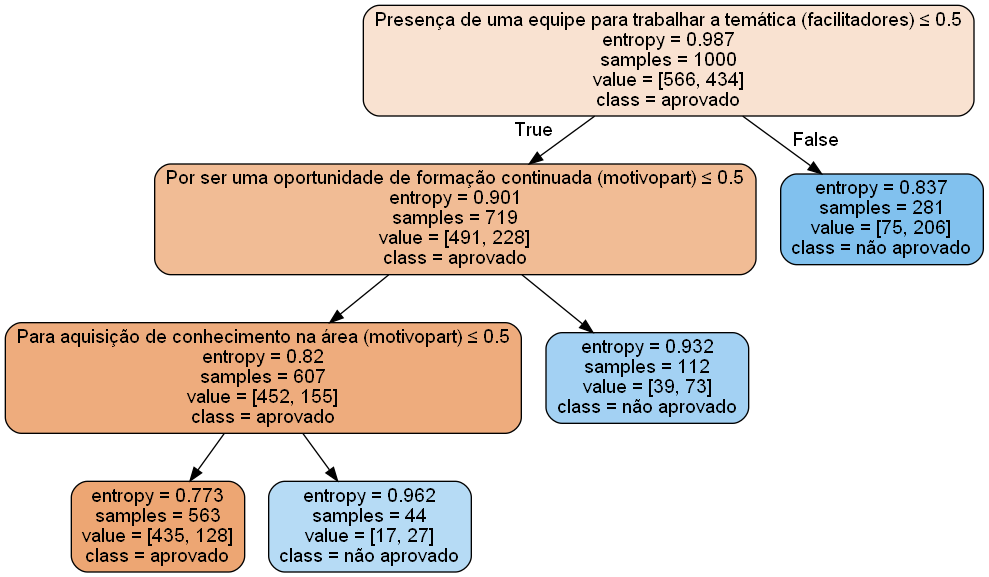

In [326]:
model = decisionTree(df_sociais, y, insideDTreeBalancing=False)

X_treino: 750 0.75
X_teste: 250 0.25
y_treino: 750 0.75
y_teste: 250 0.25


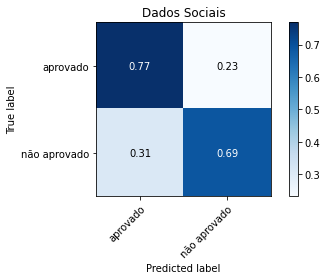

Acurácia do modelo 0.732 



,Predicted Unconfirmed,Predicted Confirmed
True Unconfirmed,103,31
True Confirmed,36,80


In [327]:
make_confusion_matrix(df_sociais, y, model, 'Dados Sociais')

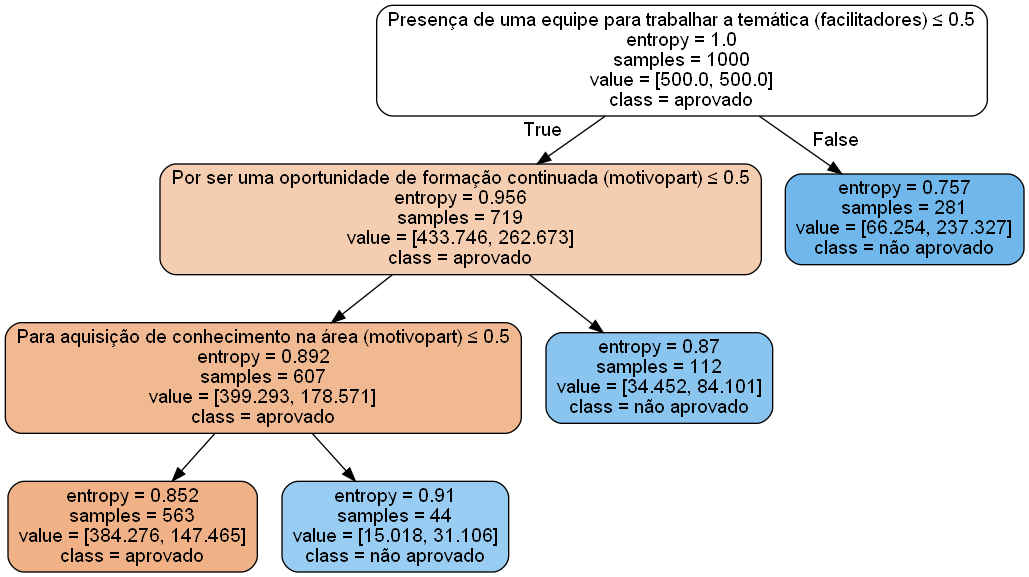

In [328]:
model = decisionTree(df_sociais, y, insideDTreeBalancing=True)

X_treino: 750 0.75
X_teste: 250 0.25
y_treino: 750 0.75
y_teste: 250 0.25


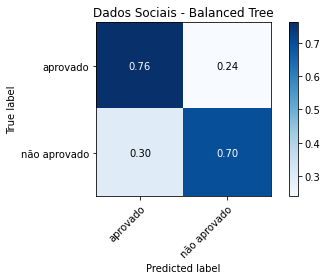

Acurácia do modelo 0.732 



,Predicted Unconfirmed,Predicted Confirmed
True Unconfirmed,102,32
True Confirmed,35,81


In [329]:
make_confusion_matrix(df_sociais, y, model, 'Dados Sociais - Balanced Tree')

#### Situação 2 - Características sócio-econômicas, perguntas iniciais e primeiro módulo do curso

In [330]:
df_situcao2 = pd.concat([df_sociais, df_modulo1], axis=1)

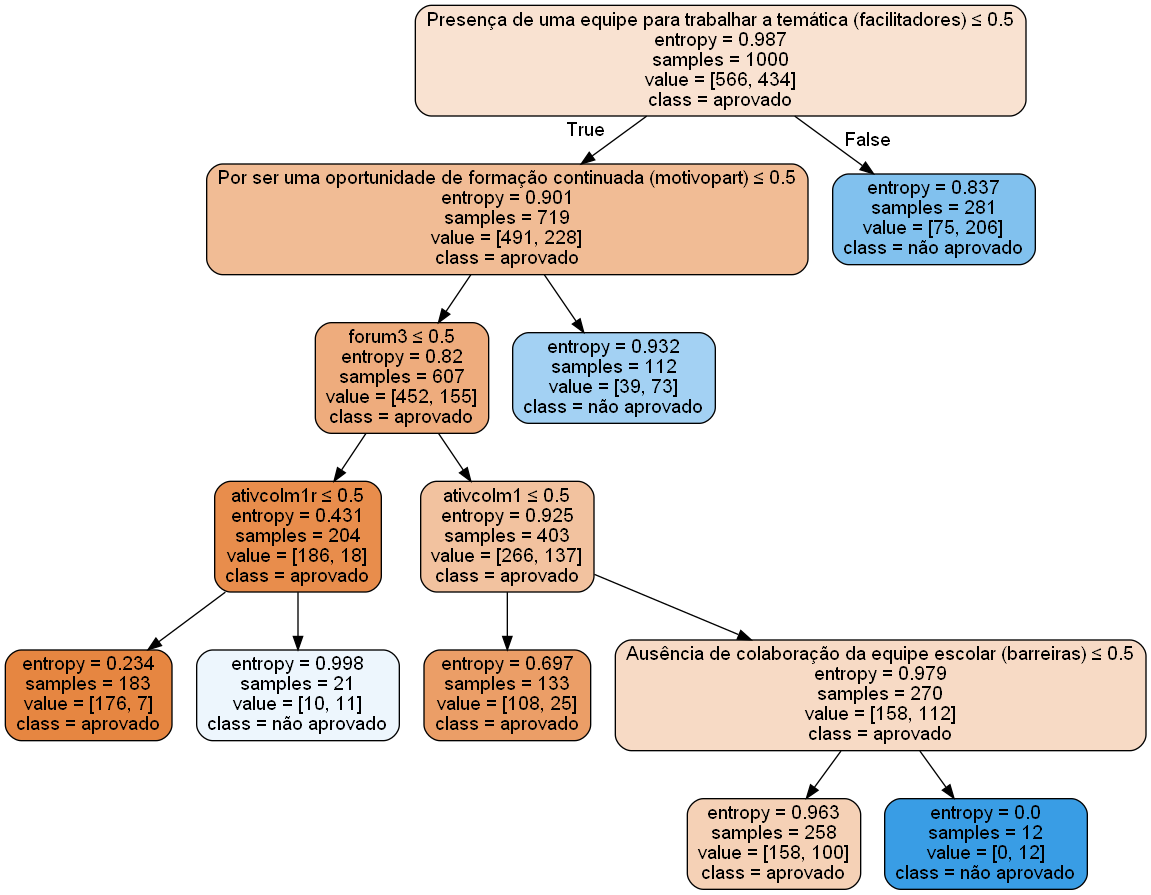

In [331]:
model = decisionTree(df_situcao2, y, insideDTreeBalancing=False)

X_treino: 750 0.75
X_teste: 250 0.25
y_treino: 750 0.75
y_teste: 250 0.25


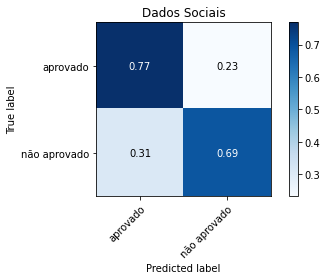

Acurácia do modelo 0.732 



,Predicted Unconfirmed,Predicted Confirmed
True Unconfirmed,103,31
True Confirmed,36,80


In [332]:
make_confusion_matrix(df_sociais, y, model, 'Dados Sociais')

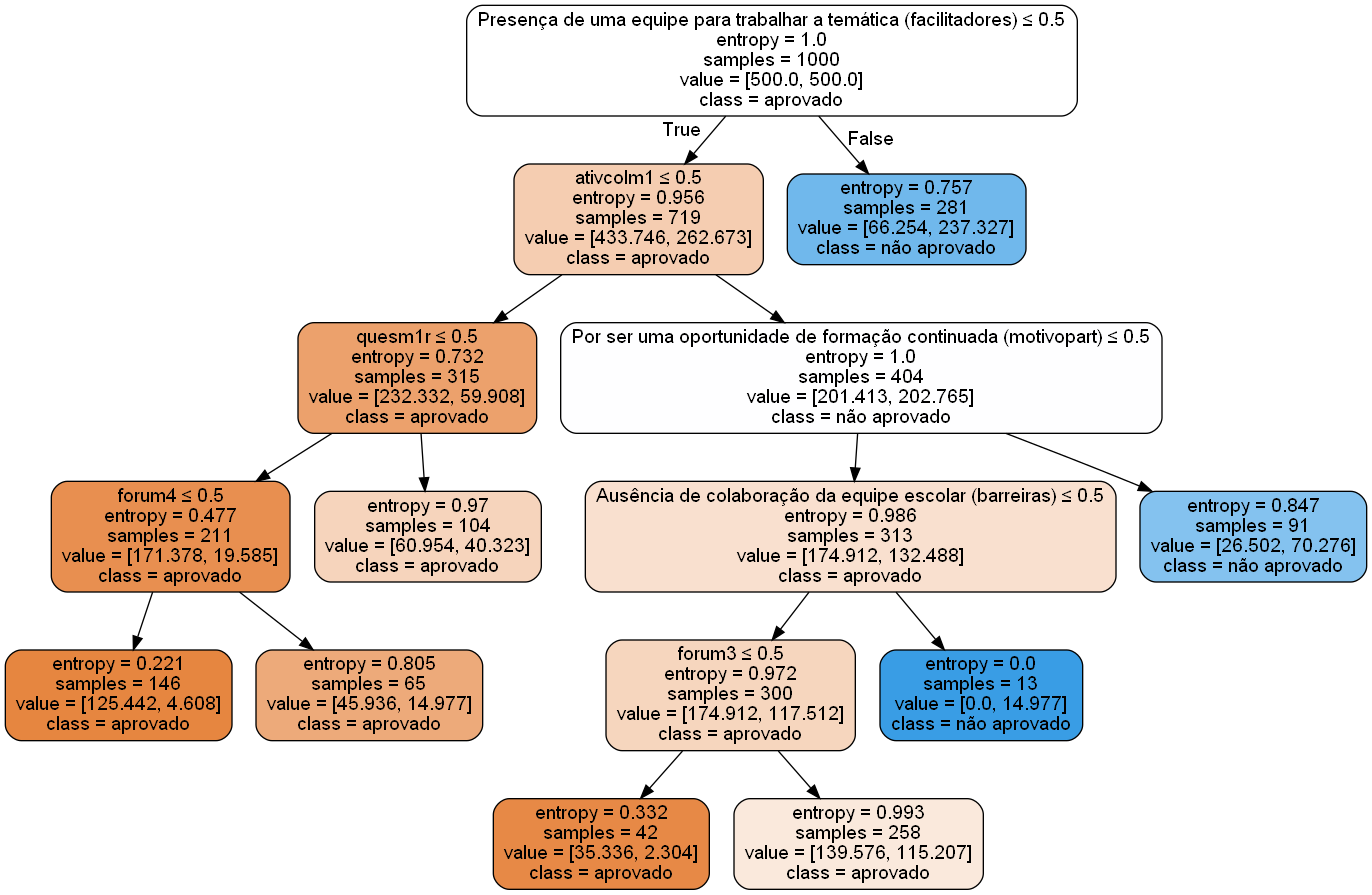

In [333]:
model = decisionTree(df_situcao2, y, insideDTreeBalancing=True)

X_treino: 750 0.75
X_teste: 250 0.25
y_treino: 750 0.75
y_teste: 250 0.25


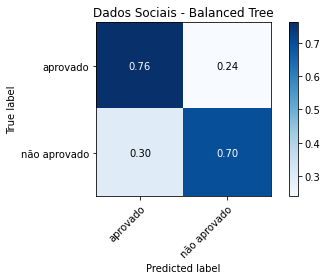

Acurácia do modelo 0.732 



,Predicted Unconfirmed,Predicted Confirmed
True Unconfirmed,102,32
True Confirmed,35,81


In [334]:
make_confusion_matrix(df_sociais, y, model, 'Dados Sociais - Balanced Tree')

#### Situação 3 - Todos os dados: Características sócio-econômicas, perguntas iniciais, primeiro e segundo módulo do curso (todos os dados)

In [335]:
df_situcao3 = pd.concat([df_situcao2, df_modulo2], axis=1)

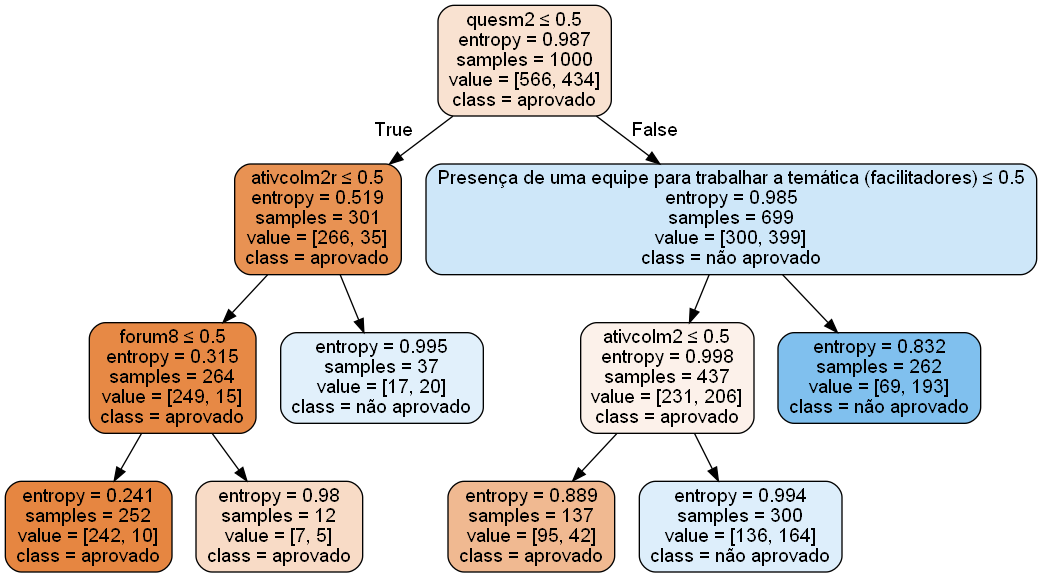

In [336]:
model = decisionTree(df_situcao3, y, insideDTreeBalancing=False)

X_treino: 750 0.75
X_teste: 250 0.25
y_treino: 750 0.75
y_teste: 250 0.25


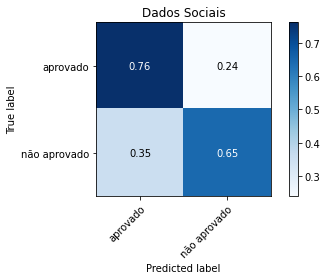

Acurácia do modelo 0.708 



,Predicted Unconfirmed,Predicted Confirmed
True Unconfirmed,102,32
True Confirmed,41,75


In [337]:
make_confusion_matrix(df_sociais, y, model, 'Dados Sociais')

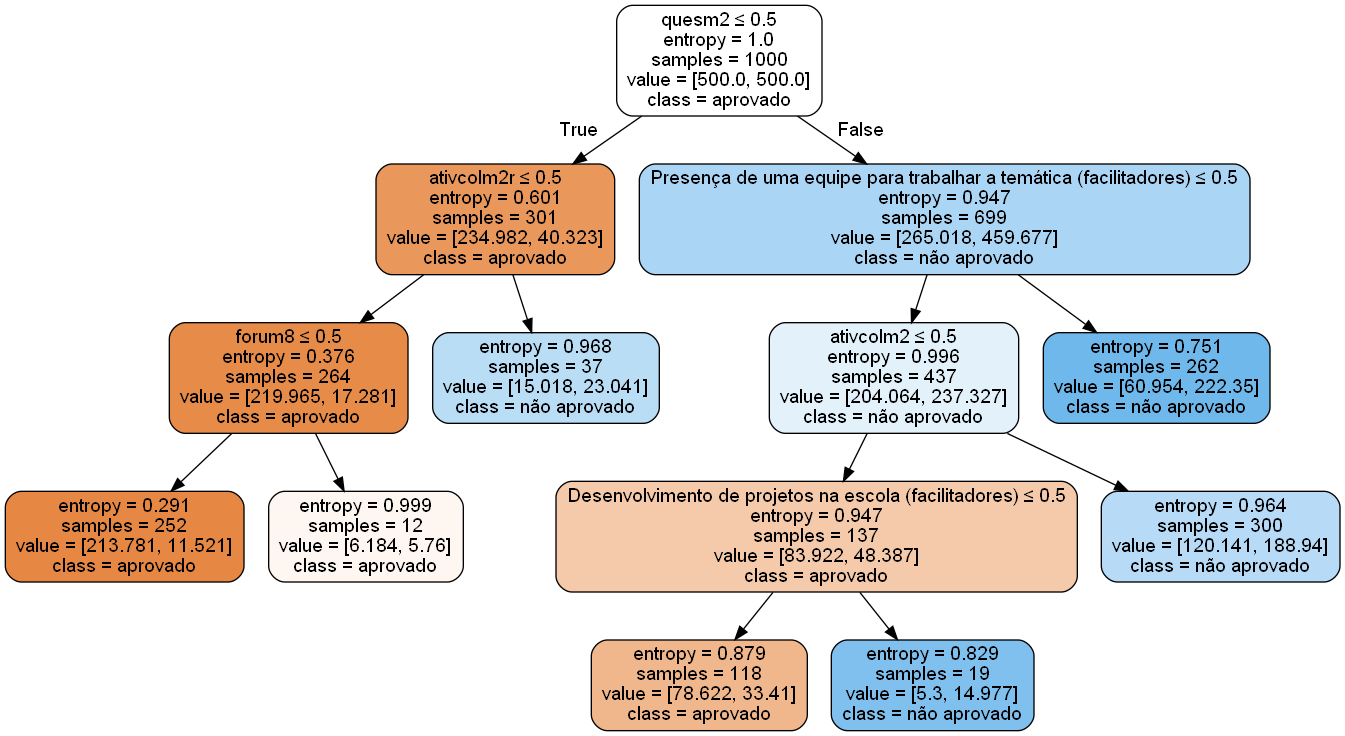

In [338]:
model = decisionTree(df_situcao3, y, insideDTreeBalancing=True)

X_treino: 750 0.75
X_teste: 250 0.25
y_treino: 750 0.75
y_teste: 250 0.25


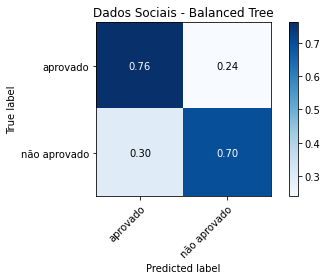

Acurácia do modelo 0.732 



,Predicted Unconfirmed,Predicted Confirmed
True Unconfirmed,102,32
True Confirmed,35,81


In [339]:
make_confusion_matrix(df_sociais, y, model, 'Dados Sociais - Balanced Tree')